In [ ]:
!git clone https://github.com/benson-au/pokemon_sprite_diffusion.git
%cd pokemon_sprite_diffusion

Cloning into 'pokemon_sprite_diffusion'...
remote: Enumerating objects: 492, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 492 (delta 61), reused 24 (delta 24), pack-reused 396 (from 4)
Receiving objects: 100% (492/492), 69.93 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (251/251), done.
/content/pokemon_sprite_diffusion/pokemon_sprite_diffusion


In [ ]:
import torch
from torchvision import transforms, utils
from model import diffusion_transformer
from utils import image_processing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Load model weights
checkpoint = torch.load("./weights/4500.pth", map_location=device, weights_only=True)
hparams = checkpoint["hparams"]

# Reconstruct the denoiser using the saved hyperparameters.
denoise_fn = diffusion_transformer.DiffusionTransformer(
    image_size=hparams["image_size"],
    patch_size=hparams["patch_size"],
    in_channels=hparams["in_channels"],
    emb_dim=hparams["emb_dim"],
    depth=hparams["depth"],
    nheads=hparams["nheads"],
    mlp_ratio=hparams["mlp_ratio"],
    time_emb_dim=hparams["time_emb_dim"]
).to(device)

# Reconstruct the diffusion model.
diffusion = diffusion_transformer.GaussianDiffusion(
    denoise_fn=denoise_fn,
    timesteps=hparams["timesteps"],
    beta_start=hparams["beta_start"],
    beta_end=hparams["beta_end"],
    schedule=hparams["schedule"]
).to(device)

# Load the state_dict.
diffusion.load_state_dict(checkpoint["diffusion_state_dict"])

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode
diffusion.eval()

GaussianDiffusion(
  (denoise_fn): DiffusionTransformer(
    (patch_embed): Conv2d(3, 288, kernel_size=(4, 4), stride=(4, 4))
    (time_mlp): Sequential(
      (0): Linear(in_features=128, out_features=288, bias=True)
      (1): ReLU()
      (2): Linear(in_features=288, out_features=288, bias=True)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-15): 16 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=288, out_features=288, bias=True)
          )
          (linear1): Linear(in_features=288, out_features=1152, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1152, out_features=288, bias=True)
          (norm1): LayerNorm((288,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((288,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dro

In [ ]:
# Square root of the harmonic mean of the variance schedule, used to rescale white noise input during inference
sqrt_harmonic_mean = torch.sqrt(1/((1/(1-diffusion.alphas_cumprod)).mean()))

Reverse diffusion: 100%|██████████| 1000/1000 [00:15<00:00, 65.59it/s]


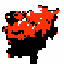

In [ ]:
# Set the seed for reproducibility
# Single pokemon generation with final output only
torch.manual_seed(2)
noise = torch.randn(3, 64, 64, device=device)*sqrt_harmonic_mean
new_pokemon = diffusion.reverse_diffusion(x_T = noise, device=device, return_pil=True)
new_pokemon

Reverse diffusion: 100%|██████████| 1000/1000 [00:09<00:00, 105.33it/s]


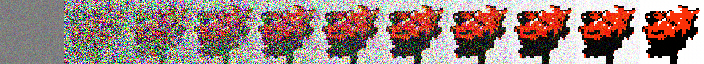

In [ ]:
# Single pokemon generation with intermediate steps
torch.manual_seed(2)
noise = torch.randn(3, 64, 64, device=device)*sqrt_harmonic_mean
new_pokemon_intermediate = diffusion.reverse_diffusion(x_T = noise, device=device, save_intermediate = 100, return_pil=True)
image_processing.pil_grid(new_pokemon_intermediate, cols=11)

Reverse diffusion: 100%|██████████| 1000/1000 [00:07<00:00, 137.93it/s]


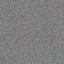

In [ ]:
# Single pokemon generation with intermediate steps combined into a GIF (saved in the folder pokemon_sprite_diffusion)
torch.manual_seed(2)
noise = torch.randn(3, 64, 64, device=device)*sqrt_harmonic_mean
new_pokemon_gif_frames = diffusion.reverse_diffusion(x_T = noise, device=device, save_intermediate = 50, return_pil=True)
new_pokemon_gif = image_processing.pils_to_gif(new_pokemon_gif_frames, display = True, duration = [100]*20 + [1000])
new_pokemon_gif

Reverse diffusion: 100%|██████████| 1000/1000 [00:07<00:00, 132.75it/s]


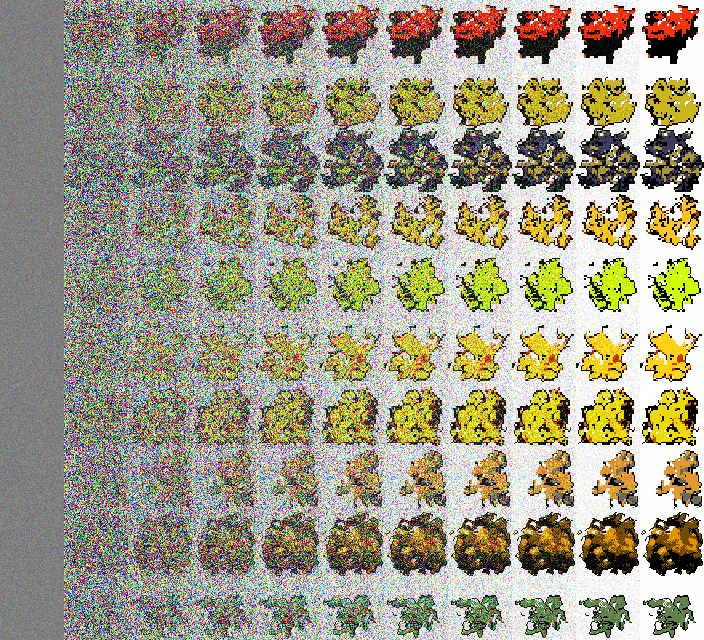

In [ ]:
# Multiple pokemon generation with intermediate steps arranged in a grid
torch.manual_seed(2)
list_of_images = []
for i in range(10):
  noise = torch.randn(3, 64, 64, device=device)*sqrt_harmonic_mean
  reversed_pil = diffusion.reverse_diffusion(x_T = noise, device=device, save_intermediate=100, return_pil=True)
  list_of_images.extend(reversed_pil)

grid_of_new_pokemon = image_processing.pil_grid(list_of_images, cols=11)
grid_of_new_pokemon

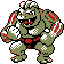

In [ ]:
# Forward diffusion of actual Pokemon
actual_pokemon = image_processing.load_images_tensor("./images/actual_pokemon")
actual_pokemon = actual_pokemon.to(device)
image_processing.tensor_to_pil(actual_pokemon[0])

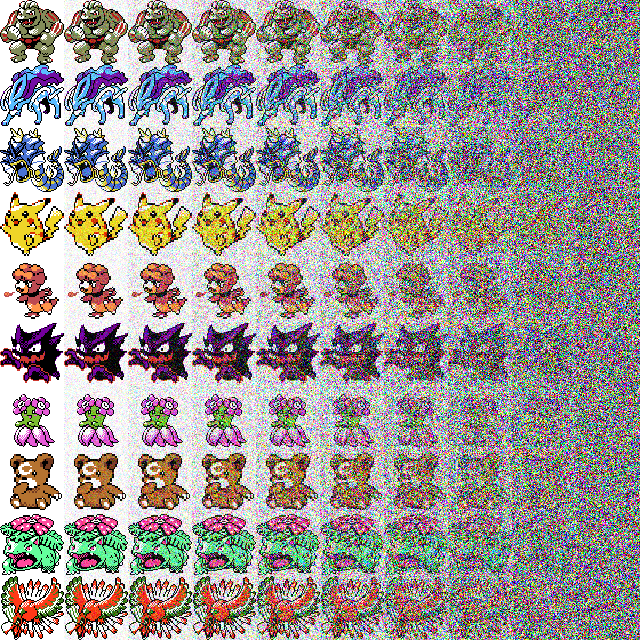

In [ ]:
torch.manual_seed(100)
forward_cascade = []

for tensor in actual_pokemon:
  forward_diffusion = diffusion.forward_diffusion_cascade(tensor, device, rate = 112, return_pil=True)
  forward_cascade.extend(forward_diffusion)

github_grid = image_processing.pil_grid(forward_cascade, cols=10)
github_grid